## Data Exploration/Analysis

Ultimate goal is to predict median sale price per square foot of a house in the neighborhood.

Current step: EDA

Next step: PCA and Clustering. See what patterns emerge in the clusters.

Final step: predict median sale price.

Important to remember: we only want to predict *home values*, not all real estate values. 

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [88]:
df= pd.read_csv('merged.csv')

In [89]:
def integizer(string):
    for i in string:
        if i == '':
            return None
        else:
            return int(i)

def dolcomma(col):
    return pd.to_numeric(col.map(lambda x: x.replace(',', '').replace('$','')), downcast='integer')

def floatizer(string):
    for i in string:
        if i == '':
            return None
        else:
            continue
    return float(string)

In [90]:
#Cleaning up monetary columns and converting to integer
df['Assessment Improvement Improved']=dolcomma(df['Assessment Land'])
df['Most Recent Sale Price Improved'] =dolcomma(df['Most Recent Sale Price'])
df['Square Footage Improved'] = dolcomma(df['Square Footage'])
df['Improvement Value Improved']= dolcomma(df['Improvement Value'])
df['Assessment Total Improved']= dolcomma(df['Assessment Total'])
df['Land Value Improved']=dolcomma(df['Land Value'])
df['Assessment Land Improved']=dolcomma(df['Assessment Land'])
df['Total Appraisal Value Improved']=dolcomma(df['Total Appraisal Value'])

In [91]:
#Cleaning up certain date columns
df['Most Recent Sale Date Improved']=pd.to_datetime(df['Most Recent Sale Date'])
df['Sale Date Improved']=pd.to_datetime(df['Sale Date'])

In [92]:
#Converting 'Land Area' column to clean float
df['Land Area Acres'] = df['Land Area'].map(lambda x: x.replace(' ','').replace('Acres', '')).map(lambda x: float(x))

In [93]:
df['Land Value Improved'].head(10)
#I noticed adjacent parcels will often all have the same appraised land value.

0    80000.0
1    80000.0
2    80000.0
3    80000.0
4    83200.0
5    65000.0
6      800.0
7    65000.0
8    65000.0
9    65000.0
Name: Land Value Improved, dtype: float64

In [94]:
#Neighborhood column is all numbers, but it's categorical.
df.Neighborhood = df.Neighborhood.map(lambda x: str(x))

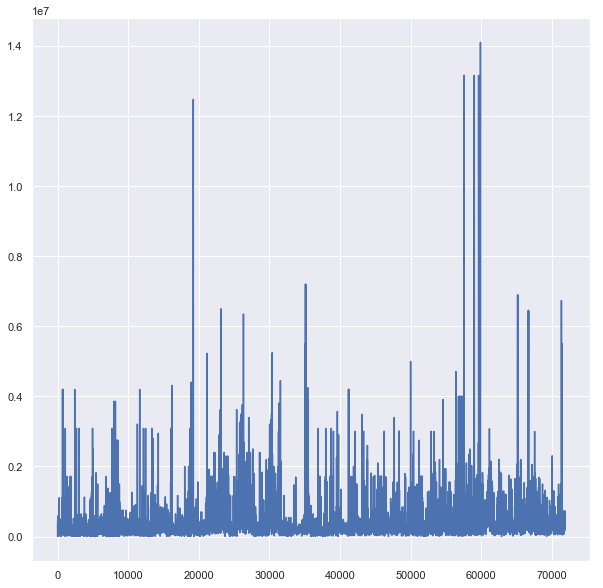

In [10]:
from pandas import Series
plt.figure(figsize=(10,10))
Series(df['Sale Price']).plot()

#Need to update this to show Median value by month or neighborhood

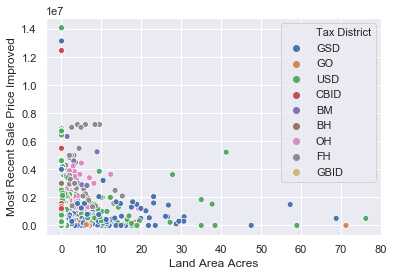

In [36]:
sns.scatterplot(y=df['Most Recent Sale Price Improved'],x=df['Land Area Acres'], hue = df['Tax District'])

In [158]:
#Many neighborhoods only have 1 or 2 observations. We need to delete neighborhoods with 3 or less observations.
df['Neighborhood'].value_counts()
#.gt() = 'greater than'
s=df.Neighborhood.value_counts().gt(3)
df.loc[df.Neighborhood.isin(s[s].index)].shape
#Removes 124 observations from original dataframe.

(71696, 58)

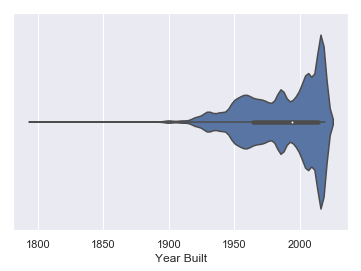

In [16]:
sns.violinplot(df['Year Built'])

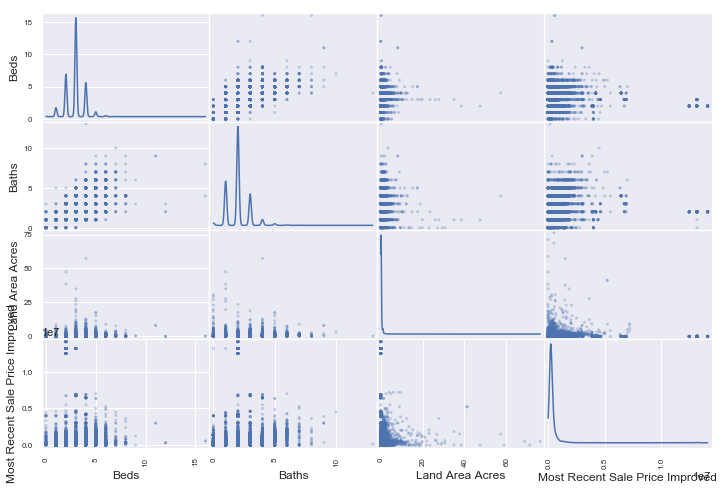

In [203]:
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

In [96]:
type(df['Story Height'])
#Need to convert this to numeric. Split-level = 1.5, 1.75 story= 1.5
df['Story Height Improved'] = df['Story Height'].astype(str).map(lambda x: x.replace('STY', '').replace('STORY','').replace(' ', '').replace('TWO', '2').replace('ONE', '1'))
df['Story Height Improved']=df['Story Height Improved'].map(lambda x: x.replace('THREE', '3').replace('SPLIT-LEVEL','1.5').replace('BI-LEVEL', '2')).replace('1.75','1.5')
df['Story Height Improved']=df['Story Height Improved'].map(lambda x: float(x))

print(df['Story Height Improved'].head(40))

0     2.0
1     1.5
2     1.5
3     1.5
4     1.0
5     1.0
6     NaN
7     1.0
8     2.0
9     1.0
10    2.0
11    2.0
12    1.0
13    NaN
14    1.0
15    1.0
16    1.0
17    1.0
18    1.5
19    2.0
20    1.0
21    1.0
22    1.5
23    1.0
24    1.0
25    1.0
26    1.0
27    1.0
28    1.0
29    1.0
30    1.0
31    1.0
32    1.0
33    2.0
34    2.0
35    2.0
36    2.0
37    2.0
38    2.0
39    1.5
Name: Story Height Improved, dtype: float64


In [51]:
len(df['Neighborhood'].unique())
#This will be getting pretty granular

830

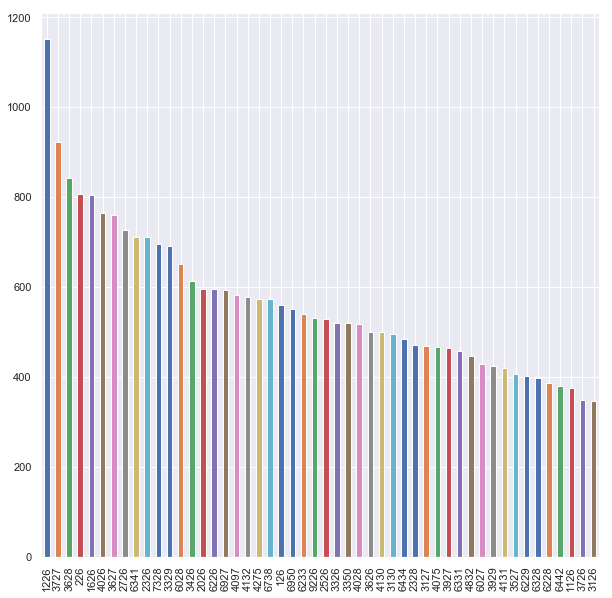

In [58]:
plt.figure(figsize=(10,10))
df.Neighborhood.value_counts()[:50].plot('bar')
plt.show()
#Nice even class distribution

In [97]:
#I'm going to clean up the classifications here, combine similar values
#Rural = Ag/Res = Res/Ag = Res/Forest = Farm/Agr = FRM
df['Assessment Classification'] = df['Assessment Classification'].replace('FOREST/RES', 'RURAL').replace('RES/AGR', 'RURAL').replace('FARM/AGR', 'RURAL').replace('FRST/FRM', 'RURAL')
df['Assessment Classification'] = df['Assessment Classification'].replace('AG/RES', 'RURAL').replace('RES/FOREST', 'RURAL').replace('FRM','RURAL')
df['Assessment Classification']= df['Assessment Classification'].replace('')
print(df['Assessment Classification'].value_counts())

RES        69245
COM         2435
EXE           46
RURAL         38
RES/COM       16
CA/OS         15
COM/RES       12
AO             9
EXE VAC        1
EXE/COM        1
OSAP           1
GOV            1
Name: Assessment Classification, dtype: int64


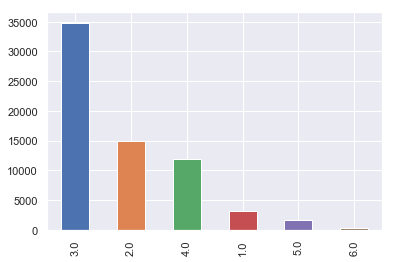

In [122]:
df.Beds.value_counts()[:6].plot('bar')

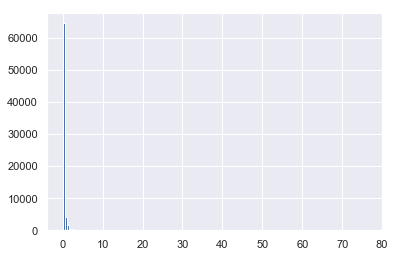

In [20]:
df['Land Area Acres'].hist(bins=150)
#We have some outliers, consider removing
#Important observation: the vsat majority of these units are multifamily (land area of 0)

In [138]:
#Add 0.5 to Baths for each "half bath" listed?
#Or not. This is a potential indicator of PPSF
df['Half Bath'].value_counts()

0.0    38723
1.0    27447
2.0     1031
3.0       56
4.0       10
5.0        3
Name: Half Bath, dtype: int64

In [19]:
df['Building Condition'].value_counts()

Average        65906
Fair             761
Good             271
Poor             119
Very Good         49
Very Poor         34
Dilapidated       25
Excellent         11
Name: Building Condition, dtype: int64

In [142]:
df['Building Grade'].value_counts()
#We cannot use this variable. There is no guide on the Davidson CO site to what these indicate.

C      43938
B      17011
D       2648
A       2220
X       1140
E        128
SRB       21
TCC       18
OFB       14
SRC        8
AAC        4
OFD        3
TCD        3
IDC        2
ALB        2
SSD        2
TCB        2
OFC        2
IDD        1
SMD        1
ODB        1
ODC        1
SGB        1
SSC        1
TFC        1
SSB        1
ACB        1
Name: Building Grade, dtype: int64

In [59]:
df['Building Type'].value_counts()

SINGLE FAM    46927
CONDO         17177
ZERO LOT       1558
PLEX           1428
COMM             61
THIRD            24
Name: Building Type, dtype: int64

In [98]:
#All apartments and multifamily I am listing as "condo"
df['Building Type']= df['Building Type'].replace('HIGHRISE APT', 'CONDO').replace('APARTMENT', 'CONDO').replace('HRISE CONDO', 'CONDO').replace('RESD CONDO', 'CONDO')
#Combining single-family residential
df['Building Type']=df['Building Type'].replace('RW SING FAM', 'SINGLE FAM').replace('RZ SING FAM', 'SINGLE FAM').replace('RH SING FAM', 'SINGLE FAM').replace('RY SING FAM', 'SINGLE FAM').replace('MODULAR HOME', 'SINGLE FAM').replace('SING FAM', 'SINGLE FAM')
#Combining all townhomes up to quadplexes
df['Building Type']=df['Building Type'].replace('RESD TRIPLEX', 'PLEX').replace('RESD QUADPLX', 'PLEX').replace('R1 DUPLEX', 'PLEX').replace('RES DUPLEX', 'PLEX')
#Combining "third places"
df['Building Type']=df['Building Type'].replace('LODGE/FRAT\'L', 'THIRD').replace('CHURCH', 'THIRD')
#Combining commercial
df['Building Type']=df['Building Type'].replace('HEALTH CLUB', 'COMM').replace('GROCERY/SMKT', 'COMM').replace('RETAIL/SHPG', 'COMM').replace('DAYCARE', 'COMM').replace('MARKET', 'COMM').replace('REST/BAR', 'COMM')
df['Building Type']=df['Building Type'].replace('OFFICE', 'COMM').replace('WAREHOUSE', 'COMM')

In [99]:
med_value={}
nbhds = df['Neighborhood'].unique()
for g in nbhds:
    nbhd_group= df[df['Neighborhood'] == g]
    nbhd_med=nbhd_group['Most Recent Sale Price Improved'].median()
    med_value[g]= nbhd_med

len(med_value)

830

In [102]:
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
column = df.groupby('Neighborhood').mean()
column['Mean PPS'] = column['Sale Price'] / column['Square Footage Improved']
column['Mean PPS']=column['Mean PPS'].replace(np.inf, np.nan)
column['Mean PPS'].unique()

array([  360.57236895,   228.83502171,   382.20188031,   328.18532819,
         280.8452381 ,   343.8720634 ,            nan,   395.04690603,
         147.24822936,   230.25782144,   192.86339755,   212.51445623,
         201.95229716,   268.40235458,   224.51723364,  7142.00204813,
         255.5541498 ,   235.66459172,   234.52611219,   205.54495196,
         286.28939559,   286.45508134,   190.07059686,   187.00762297,
         325.02086069,   192.30525524,   227.21254355,   185.13927577,
         228.46844444,   877.22869808,   246.81019585,   216.83333333,
         261.34192315,   274.80940598,   488.08541578,   276.15126484,
         260.11560694,   319.13600847,   275.62672587,   334.15180951,
         264.51788821,   309.91735537,   241.90313203,   418.97186415,
         305.53857008,   181.86629814,   228.83605187,   184.50838507,
         211.03461465,   277.78430124,   601.97533445,   225.60750538,
         228.44827586,   311.60429936,   183.01610542,   742.74285907,
      

In [103]:
meansales = pd.DataFrame(column['Mean PPS'])
df=df.merge(meansales,how = 'left', on = 'Neighborhood')

In [104]:
print(df['Mean PPS'].unique())
print(df['Med PPS'].unique())

[  121.12216177   112.76695824   137.49776159   117.7665889
   115.78044832   117.62372017   107.82638093   114.65336263
   107.45399361   203.87658894    96.63784822   102.06867317
   118.78188444   108.09434591   136.20775975    85.97714165
    92.2293183    117.66624904   128.52819984   106.72115599
   115.27907637   126.40492168   109.75069511   155.32049474
    92.28976094   185.25134174    76.62147271    84.82222123
   140.79737042   369.95886616  1273.14814815   113.32417582
    92.20451527   187.54587335   126.7649994    102.5844534
   123.03075377   118.20433181   112.0660785    256.57161824
   226.70250896    85.7512357    230.84164618   159.05782648
            nan   129.47804922    99.44828521   128.2268303
    80.5021795    194.32449668   143.47894301   127.24134886
   163.98544266   129.6475266    134.67145564   143.54199432
    67.71821541   126.27705608   150.85450363   146.44978053
    83.9807465    130.91934039   129.44471136   112.05673926
   103.03083568   140.44630

KeyError: 'Med PPS'

In [146]:
from sklearn.preprocessing import LabelEncoder
df2=df[['Half Bath', 'Building Type','Rooms', 'Mean PPS', 'Multiple Parcels Involved in Sale', 'Year Built','Story Height Improved']].dropna()
X = pd.get_dummies(df2[['Half Bath','Rooms','Multiple Parcels Involved in Sale', 'Building Type', 'Year Built','Story Height Improved']])
y= df2['Mean PPS']
#le = LabelEncoder()
#y = le.fit_transform(y)

In [149]:
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as MSE

model = DTR()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3,random_state=4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(MSE(y_test, y_pred)**0.5)
print(df['Mean PPS'].mean())

218.703662472073
217.38558166031643


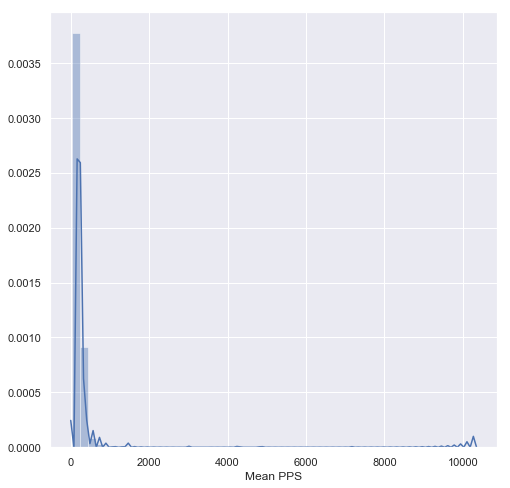

In [153]:
#This is the cause of the high RMSE. Outliers need cleaning.
plt.figure(figsize=(8,8))
sns.distplot(df['Mean PPS'].dropna())

In [150]:
from sklearn.dummy import DummyRegressor as DR
model=DR()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3,random_state=4)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
print(MSE(y_test, y_pred)**0.5)

442.5748538612646


In [154]:
from sklearn.neighbors import KNeighborsRegressor as KNR
knr = KNR()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3,random_state=4)
knr.fit(X_train,y_train)
y_pred = knr.predict(X_test)
print(MSE(y_test, y_pred)**0.5)

222.9230950695411


In [155]:
from xgboost import XGBRegressor as XGBR
xgbr = XGBR()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.3,random_state=4)
xgbr.fit(X_train,y_train)
y_pred = xgbr.predict(X_test)
print(MSE(y_test, y_pred)**0.5)

300.52520436167686
